In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import tensorflow as tf
import keras
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import Xception, NASNetLarge, NASNetMobile, InceptionResNetV2, EfficientNetB0
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 100

In [2]:
fold = pd.read_csv('../input/dataset-split-new-resized-data/new-5-fold.csv')
fold.head()

,id_code,diagnosis,data,fold_0,fold_1,fold_2,fold_3,fold_4
0,../input/resized-2015-2019-blindness-detection-images/resized train 19/000c1434d8d7.jpg,2,new,train,train,train,validation,train
1,../input/resized-2015-2019-blindness-detection-images/resized train 19/001639a390f0.jpg,4,new,train,train,train,train,validation
2,../input/resized-2015-2019-blindness-detection-images/resized train 19/0024cdab0c1e.jpg,1,new,validation,train,train,train,train
3,../input/resized-2015-2019-blindness-detection-images/resized train 19/002c21358ce6.jpg,0,new,train,train,train,validation,train
4,../input/resized-2015-2019-blindness-detection-images/resized train 19/005b95c28852.jpg,0,new,validation,train,train,train,train


In [3]:
fold4_train = fold[fold['fold_4'] == 'train'][['id_code','diagnosis']]
fold4_valid = fold[fold['fold_4'] == 'validation'][['id_code','diagnosis']]
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

In [4]:
test['id_code'] = test['id_code'].apply(lambda x: x + '.png')
train['id_code'] = train['id_code'].apply(lambda x: x + '.png')

In [5]:
fold4_train.shape, fold4_valid.shape

((2930, 2), (732, 2))

In [6]:
# Model parameters
BATCH_SIZE = 10
EPOCHS = 10
WARMUP_EPOCHS = 3
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = fold4_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

metric_list = ["accuracy"]

In [7]:
fold4_train['diagnosis'] = fold4_train['diagnosis'].astype(str)
fold4_valid['diagnosis'] = fold4_valid['diagnosis'].astype(str)

In [8]:
datagen=ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)

train_generator=datagen.flow_from_dataframe(
                        dataframe=fold4_train,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="categorical",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH))

valid_generator=datagen.flow_from_dataframe(
                        dataframe=fold4_valid,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="categorical",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH))

test_generator=datagen.flow_from_dataframe(  
                       dataframe=test,
                       directory='../input/aptos2019-blindness-detection/test_images',
                       x_col="id_code",
                       batch_size=1,
                       class_mode=None,
                       shuffle=False,
                       target_size=(HEIGHT, WIDTH))

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [9]:
def create_model(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB0(weights='imagenet', 
                                       include_top=False,
                                       input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(5, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [10]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL))

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

2022-02-15 12:46:20.446205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 12:46:20.540578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 12:46:20.541318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 12:46:20.542948: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
_____________________________

In [11]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit(train_generator,
                                     validation_data=valid_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=5,
                                     verbose=1).history

2022-02-15 12:46:25.479606: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-02-15 12:46:31.677102: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


293/293 [==============================] - 276s 907ms/step - loss: 1.3672 - accuracy: 0.4539 - val_loss: 1.3040 - val_accuracy: 0.4932
Epoch 2/5
293/293 [==============================] - 236s 807ms/step - loss: 1.3244 - accuracy: 0.4792 - val_loss: 1.3060 - val_accuracy: 0.4918
Epoch 3/5
293/293 [==============================] - 236s 806ms/step - loss: 1.3233 - accuracy: 0.4857 - val_loss: 1.2982 - val_accuracy: 0.4945
Epoch 4/5
293/293 [==============================] - 237s 810ms/step - loss: 1.3191 - accuracy: 0.4935 - val_loss: 1.2958 - val_accuracy: 0.4932
Epoch 5/5
293/293 [==============================] - 241s 821ms/step - loss: 1.3231 - accuracy: 0.4915 - val_loss: 1.2946 - val_accuracy: 0.4945


In [12]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [13]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=10,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/10
293/293 [==============================] - 284s 942ms/step - loss: 0.2858 - accuracy: 0.7034 - val_loss: 0.4785 - val_accuracy: 0.5110
Epoch 2/10
293/293 [==============================] - 273s 931ms/step - loss: 0.2206 - accuracy: 0.7614 - val_loss: 4.2310 - val_accuracy: 0.5027
Epoch 3/10
293/293 [==============================] - 279s 952ms/step - loss: 0.1929 - accuracy: 0.7966 - val_loss: 46.3510 - val_accuracy: 0.4945
Epoch 4/10
293/293 [==============================] - 273s 931ms/step - loss: 0.1768 - accuracy: 0.8157 - val_loss: 33.6916 - val_accuracy: 0.4932

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/10
293/293 [==============================] - 274s 933ms/step - loss: 0.1624 - accuracy: 0.8304 - val_loss: 0.4846 - val_accuracy: 0.5904
Epoch 6/10
293/293 [==============================] - 274s 933ms/step - loss: 0.1561 - accuracy: 0.8324 - val_loss: 32742.3594 - val_accuracy: 0.4918
Restoring model weights from the end 

In [14]:
model.save('EfficientNetB0-f0-new.h5')

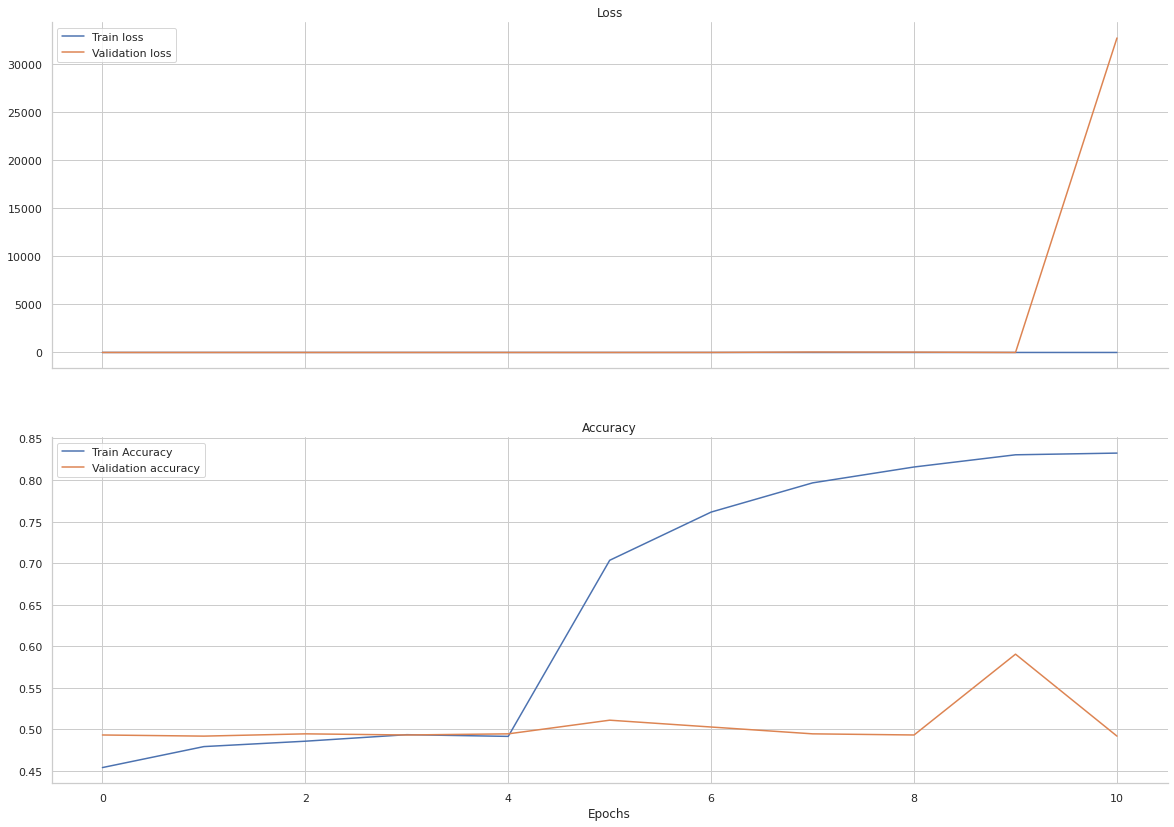

In [15]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [16]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


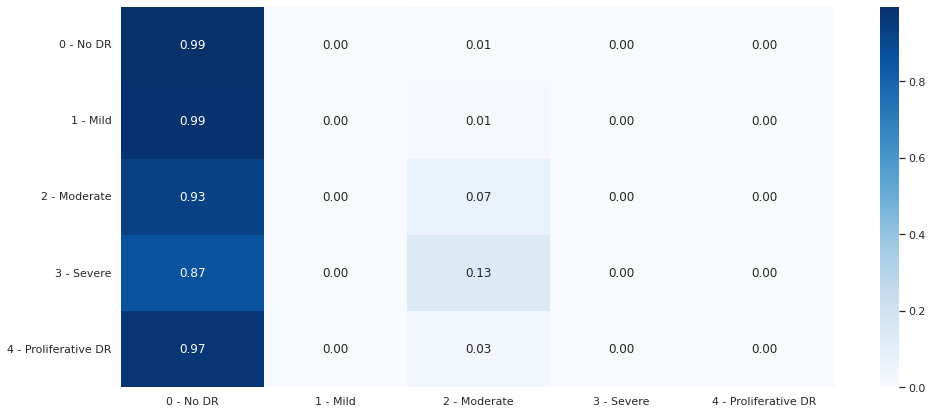

In [17]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [18]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.046


In [19]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0
5,009c019a7309,0
6,010d915e229a,0
7,0111b949947e,0
8,01499815e469,0
9,0167076e7089,0


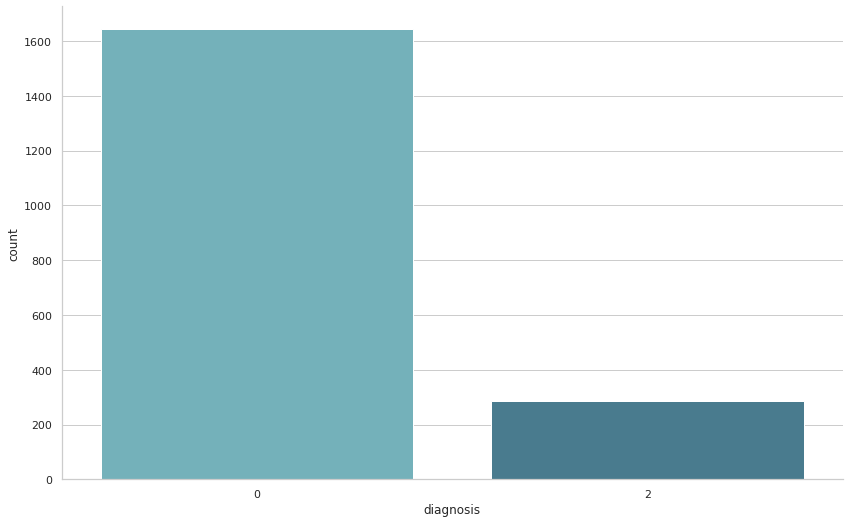

In [20]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()